<a href="https://colab.research.google.com/github/abhigoogol/Autoencoders-using-Pytorch/blob/master/01_Autoencoder_Classifier_End_to_End_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import copy

plt.style.use('default')

In [0]:
transform = transforms.ToTensor()

traindataset = datasets.MNIST('.', download=True, train=True, transform=transform)
testdataset = datasets.MNIST('.', download=True, train=False, transform=transform)

0it [00:00, ?it/s]

9920512it [00:02, 3845358.80it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 57172.92it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 958002.02it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21362.64it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
bs = 1000

In [0]:
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)

In [0]:
print(trainloader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: .
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [0]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 100),
        nn.ReLU())
    self.decoder = nn.Sequential(
        nn.Linear(100, 28*28),
        nn.ReLU())
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [0]:
net = AutoEncoder()
net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)

In [0]:
if torch.cuda.is_available():
  GPU = 1
  print('Training on GPU')
  net = net.cuda()

Training on GPU


In [0]:
init_weights = copy.deepcopy(net.encoder[0].weight.data)

In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

In [0]:
epochs = 10
for epoch in range(epochs):
  runningloss = 0
  
  for images, labels in trainloader:
    if GPU:
      images, labels = Variable(images.view(images.size()[0], -1)).cuda(), Variable(labels).cuda()
    
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, images.view(images.size()[0], -1))
    loss.backward()
    optimizer.step()
    runningloss += loss.item()/images.shape[0]
  print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

Epoch: 1/10 	 Mean Square Error Loss: 0.004661840900778771
Epoch: 2/10 	 Mean Square Error Loss: 0.0032763563059270374
Epoch: 3/10 	 Mean Square Error Loss: 0.0024739362113177774
Epoch: 4/10 	 Mean Square Error Loss: 0.002028492245823145
Epoch: 5/10 	 Mean Square Error Loss: 0.0017777966279536495
Epoch: 6/10 	 Mean Square Error Loss: 0.0016017712298780679
Epoch: 7/10 	 Mean Square Error Loss: 0.0014676616266369815
Epoch: 8/10 	 Mean Square Error Loss: 0.0013706545811146497
Epoch: 9/10 	 Mean Square Error Loss: 0.0012945550028234721
Epoch: 10/10 	 Mean Square Error Loss: 0.001220813697203994


# Testing Autoencoder Performance

In [0]:
next(iter(testloader))[0].shape

torch.Size([1000, 1, 28, 28])

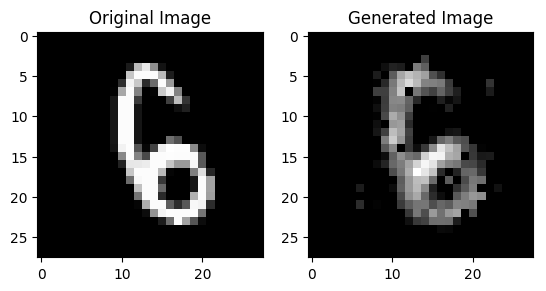

In [0]:
test_images, labels = next(iter(testloader))

if GPU:
  test_images = Variable(images.view(images.size()[0], -1)).cuda()
  test_output = net(test_images)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(inp[0].cpu(), cmap='gray')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(out[0].cpu().detach(), cmap='gray')
plt.show()

# Encoder Weights Visualization

In [0]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

d_weights = init_weights - trained_weights

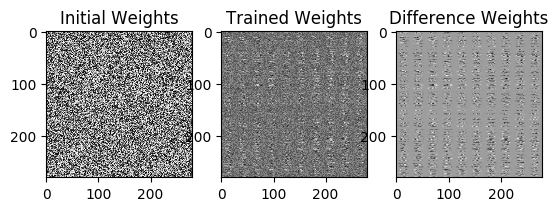

In [0]:
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
plot.set_title('Initial Weights')
imgplot = plt.imshow(init_weights.view(-1,280,280).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 2)
plot.set_title('Trained Weights')
imgplot = plt.imshow(trained_weights.view(-1,280,280).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 3)
plot.set_title('Difference Weights')
imgplot = plt.imshow(d_weights.view(-1,280,280).cpu()[0], cmap='gray')

# Remove Decoder and Add Classifier layer

In [0]:
net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)

In [0]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax(dim=1)))
print(net)
if GPU:
    net = net.cuda()
    
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [0]:
epochs = 20
for epoch in range(epochs):
  runningloss = 0
  
  for images, labels in testloader:
    if GPU:
      images, labels = Variable(images.view(images.size()[0], -1)).cuda(), Variable(labels).cuda()
#     print(images.shape, labels.shape)
    output = net(images)
    optimizer.zero_grad()
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    runningloss += loss.item()/images.shape[0]
  
  else:
    new_classifier.eval()
    total_correct = 0
    with torch.no_grad():
      for images, labels in testloader:
        if GPU:
          images, labels = Variable(images.view(images.size()[0], -1)).cuda(), Variable(labels).cuda()
          output_acc = net(images)
          _, pred = torch.max(output_acc, 1)
          total_correct += torch.sum(pred==labels).item()
    accuracy = total_correct / len(testloader.dataset)
  print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch, epochs, runningloss, accuracy))

Epoch: 0/20 	 Training Loss: 0.02280293726921082, Test Accuracy: 0.3698
Epoch: 1/20 	 Training Loss: 0.01690542721748352, Test Accuracy: 0.7265
Epoch: 2/20 	 Training Loss: 0.01198158448934555, Test Accuracy: 0.7943
Epoch: 3/20 	 Training Loss: 0.008989433407783508, Test Accuracy: 0.8079
Epoch: 4/20 	 Training Loss: 0.007345956057310104, Test Accuracy: 0.8357
Epoch: 5/20 	 Training Loss: 0.006367360770702364, Test Accuracy: 0.8435
Epoch: 6/20 	 Training Loss: 0.00577307003736496, Test Accuracy: 0.8568
Epoch: 7/20 	 Training Loss: 0.00533890414237976, Test Accuracy: 0.8637
Epoch: 8/20 	 Training Loss: 0.005025183856487275, Test Accuracy: 0.8707
Epoch: 9/20 	 Training Loss: 0.0047743129134178155, Test Accuracy: 0.8751
Epoch: 10/20 	 Training Loss: 0.004572146847844125, Test Accuracy: 0.8789
Epoch: 11/20 	 Training Loss: 0.0044029468297958375, Test Accuracy: 0.8814
Epoch: 12/20 	 Training Loss: 0.004258813619613647, Test Accuracy: 0.8846
Epoch: 13/20 	 Training Loss: 0.004134311318397522,

# Encoder Weights Visualization

In [0]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)

d_weights = cll_weights - cll_weights_ft

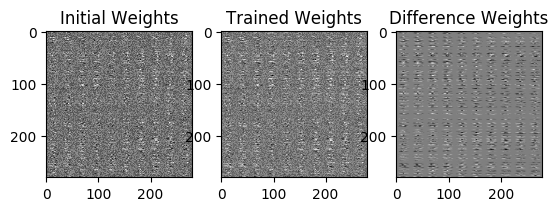

In [0]:
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
plot.set_title('Initial Weights')
imgplot = plt.imshow(cll_weights.view(-1,280,280).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 2)
plot.set_title('Trained Weights')
imgplot = plt.imshow(cll_weights_ft.view(-1,280,280).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 3)
plot.set_title('Difference Weights')
imgplot = plt.imshow(d_weights.view(-1,280,280).cpu()[0], cmap='gray')

# Classifier Weights Visualization

In [0]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

d_weights = init_classifier_weights - trained_classifier_weights

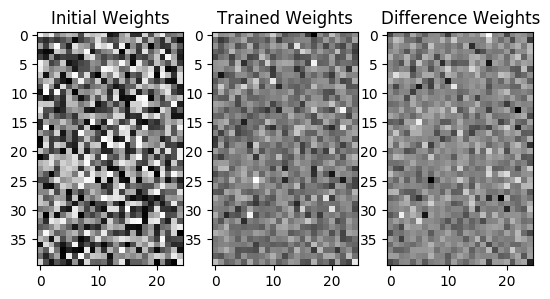

In [0]:
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
plot.set_title('Initial Weights')
imgplot = plt.imshow(init_classifier_weights.view(-1, 40, 25).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 2)
plot.set_title('Trained Weights')
imgplot = plt.imshow(trained_classifier_weights.view(-1,40, 25).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 3)
plot.set_title('Difference Weights')
imgplot = plt.imshow(d_weights.view(-1,40, 25).cpu()[0], cmap='gray')